In [1]:
import sys
sys.path.append('../..') 

# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from src.physics.pulses import GaussianPulse1D, format_value
from src.physics.crystals import KTPCrystal, KTPCrystal_Kato
from src.physics.nonlinear_optics import PhaseMatching
from src.physics.math import conv_discrete

# Pasos para generar la simulacion

1. Definir el pulso
2. Definir el cristal
3. Calcular la fase de emparejamiento (phase matching)
4. Calcular la funcion de mismatch (mismatching function)
5. Calcular convolucion del pulso de entrada
6. REalizar el producto de la funcion de mismatch, la autoconvolucion y el factor de amplitud. (Parametros definidos con anterioridad)

# Parametros inicales del pulso de entrada


In [2]:
# Parámetros iniciales
L = 0.0004  # Longitud de la cavidad en metros (0.4 mm)
gaussian_steps = 1000  # Número de pasos para la simulación del pulso gaussiano 

# Parámetros del pulso en longitud de onda
input_width_wl = 44e-9  # FWHM en metros (44 nm)
fundamental_wavelength = 795e-9  # Longitud de onda central en metros (795 nm)
fundamental_wavelength_um = fundamental_wavelength * 1e6  # en μm (0.795 μm)

# Inicializar pulso en longitud de onda
input_pulse = GaussianPulse1D(x0=fundamental_wavelength, FWHM=input_width_wl, steps=gaussian_steps, domain_width_std=5)
sigma_wavelength = input_pulse.standard_deviation()  # ~1.8728e-08 m
wavelength, A_lambda = input_pulse.generate_pulse(normalization=True)
wavelength, I_lambda = input_pulse.generate_intensity()

# Conversión a frecuencia angular (rad/s)
c = 299792458  # Velocidad de la luz en m/s
fundamental_frequency = 2 * np.pi * c / fundamental_wavelength  # Frecuencia angular central (rad/s)
sigma_frequency = (2 * np.pi * c) / (fundamental_wavelength ** 2) * sigma_wavelength  # Desviación en rad/s
FWHM_frequency = sigma_frequency * 2 * np.sqrt(2 * np.log(2))  # FWHM en rad/s

# Inicializar pulso en frecuencia
input_pulse_omega = GaussianPulse1D(x0=fundamental_frequency, FWHM=FWHM_frequency, steps=gaussian_steps, domain_width_std=5)
frequencies, A_omega = input_pulse_omega.generate_pulse(normalization=True)
frequencies, I_omega = input_pulse_omega.generate_intensity(normalization=True)

# Parámetros para SHG
SHG_frequencies = 2 * frequencies  # Frecuencias de la segunda armónica
SHG_wavelength = fundamental_wavelength / 2  # ~397.5 nm
SHG_wavelength_um = SHG_wavelength * 1e6  # ~0.3975 μm

# Imprimir parámetros
print("Parameters of the Gaussian pulse in wavelength domain:")
print("-" * 60)
pulse_dict = input_pulse.as_dict()
for key, value in pulse_dict.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")

print("\n")
print("Parameters of the Gaussian pulse in frequency domain:")
print("-" * 60)
pulse_dict_omega = input_pulse_omega.as_dict()
for key, value in pulse_dict_omega.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")

Parameters of the Gaussian pulse in wavelength domain:
------------------------------------------------------------
Center: 7.9500e-07
Fwhm: 4.4000e-08
Sigma: 1.8685e-08
Steps: 1000
Domain Width Std: 5
Computed Fwhm: 4.4001e-08


Parameters of the Gaussian pulse in frequency domain:
------------------------------------------------------------
Center: 2.3694e+15
Fwhm: 1.3114e+14
Sigma: 5.5688e+13
Steps: 1000
Domain Width Std: 5
Computed Fwhm: 1.3114e+14


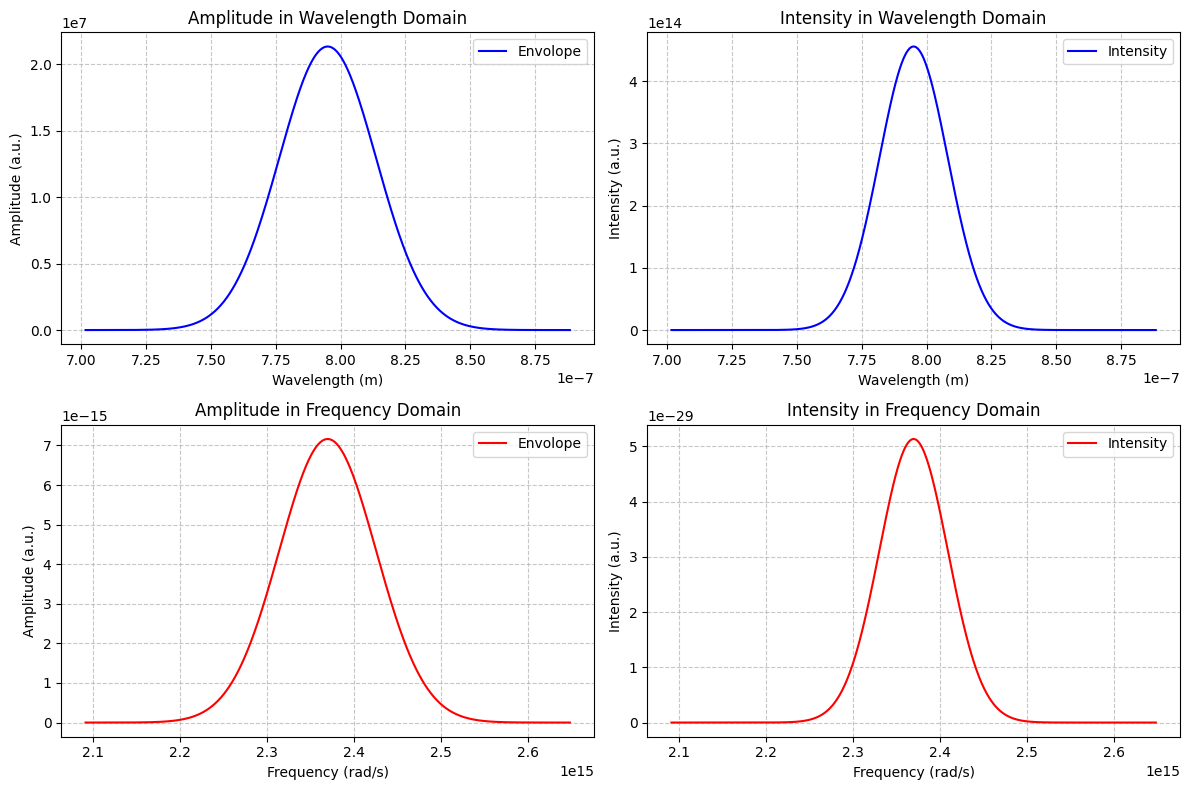

In [3]:
fig0, axs0 = plt.subplots(2, 2, figsize=(12, 8))

# Visualizacion del pulso en longitud de onda
axs0[0, 0].plot(wavelength, A_lambda, label='Envolope', color='blue')
axs0[0, 0].set_ylabel('Amplitude (a.u.)')
axs0[0, 0].set_xlabel('Wavelength (m)')
axs0[0, 0].set_title('Amplitude in Wavelength Domain')
axs0[0, 0].legend()
axs0[0, 0].grid(True, which="both", linestyle='--', alpha=0.7)

axs0[0, 1].plot(wavelength, I_lambda, label='Intensity', color='blue')
axs0[0, 1].set_ylabel('Intensity (a.u.)')
axs0[0, 1].set_xlabel('Wavelength (m)')
axs0[0, 1].set_title('Intensity in Wavelength Domain')
axs0[0, 1].legend()
axs0[0, 1].grid(True, which="both", linestyle='--', alpha=0.7)

# Visualizacion del pulso en frecuencia
axs0[1, 0].plot(frequencies, A_omega, label='Envolope', color='red')
axs0[1, 0].set_ylabel('Amplitude (a.u.)')
axs0[1, 0].set_xlabel('Frequency (rad/s)')
axs0[1, 0].set_title('Amplitude in Frequency Domain')
axs0[1, 0].legend()
axs0[1, 0].grid(True, which="both", linestyle='--', alpha=0.7)

axs0[1, 1].plot(frequencies, I_omega, label='Intensity', color='red')
axs0[1, 1].set_ylabel('Intensity (a.u.)')
axs0[1, 1].set_xlabel('Frequency (rad/s)')
axs0[1, 1].set_title('Intensity in Frequency Domain')
axs0[1, 1].legend()
axs0[1, 1].grid(True, which="both", linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
def second_harmonic_generation(pulse_y, pulse_x, SHG_frequencies, fundamental_wavelength_um, cavity_length, poling_period_um=None):
    """
    Calcula la amplitud de la segunda armónica generada a partir de un pulso Gaussiano.

    Parameters:
    -----------
    pulse_y : numpy.ndarray
        Envolvente del campo eléctrico del pulso fundamental en el dominio de frecuencia.
    pulse_x : numpy.ndarray
        Frecuencias del pulso fundamental (dominio de entrada).
    SHG_frequencies : numpy.ndarray
        Frecuencias de la segunda armónica, con la misma longitud que pulse_x.
    fundamental_wavelength_um : float
        Longitud de onda fundamental en micrómetros (ej. 0.795 para 795 nm).
    cavity_length : float
        Longitud del cristal en metros (ej. 4e-3 para 4 mm).
    poling_period_um : float, optional
        Período de quasi-phase matching en micrómetros (ej. 3.19). Si None, se usa phase matching estándar.

    Returns:
    --------
    tuple
        - SHG_amplitude : numpy.ndarray
            Amplitud del campo eléctrico de la segunda armónica en el dominio SHG_frequencies.
        - SHG_frequencies : numpy.ndarray
            Frecuencias de la segunda armónica.
        - pmf : numpy.ndarray
            Factor de phase matching aplicado.

    Notes:
    ------
    - pulse_y debe ser la envolvente del campo eléctrico (no intensidad).
    - La convolución discreta resulta en el dominio de SHG_frequencies.
    - El factor no lineal (d_eff) se asume constante (3.2e-12 m/V por defecto para KTP).
    - Requiere que pulse_x y SHG_frequencies tengan la misma longitud.
    """
    # Validación de entradas
    if len(pulse_y) != len(pulse_x):
        raise ValueError("Las longitudes de pulse_y y pulse_x deben ser iguales.")
    if len(pulse_x) != len(SHG_frequencies):
        raise ValueError("pulse_x y SHG_frequencies deben tener la misma longitud.")

    # instance of the crystal and phase matching
    ktp = KTPCrystal()
    pm = PhaseMatching(crystal=ktp, lambda_0_um=fundamental_wavelength_um)  # Calculate phase matching at fundamental wavelength
    
    # Cálculo de la función de phase matching
    if poling_period_um is None:
        # IMPORTANT:  the frequencies (pulse_x) must be the ones corresponding to the second harmonic
        pmf = pm.phase_matching_function(SHG_frequencies, cavity_length, Lambda_um=None)
    elif poling_period_um is not None:
        # IMPORTANT:  the frequencies (pulse_x) must be the ones corresponding to the second harmonic
        pmf = pm.phase_matching_function(SHG_frequencies, cavity_length, Lambda_um=poling_period_um)
        
    # Discrete convolution
    conv_result = conv_discrete(pulse_y, pulse_y, pulse_x)  # self-convolution
    
    # Prduct of the convolution with the phase matching function
    SHG_amplitud = conv_result * pmf
    
    # Factor no lineal y amplitud de SHG
    # chi_2 = 2 * 3.2e-12  # χ^(2) ≈ 2 d_eff (m/V)
    # SHG_amplitude = 1j * (omega_0 * chi_2 * cavity_length / (n_2omega * c)) * conv_result * pmf
    
    return SHG_amplitud, pulse_x, pmf

In [5]:
SHG_amplitud_no_QPM, frequencies, pmf_no_QPM = second_harmonic_generation(pulse_y=A_omega, pulse_x=frequencies, SHG_frequencies=SHG_frequencies,
                                                              fundamental_wavelength_um=fundamental_wavelength_um, cavity_length=L, poling_period_um=None)

poling_period_um = 3.19  # Período QPM en micrómetros AFINAR VALOR DEL CRISTAL
SHG_amplitud_with_QPM, frequencies, pmf_with_QPM = second_harmonic_generation(pulse_y=A_omega, pulse_x=frequencies, SHG_frequencies=SHG_frequencies,
                                                                fundamental_wavelength_um=fundamental_wavelength_um, cavity_length=L, poling_period_um=poling_period_um)

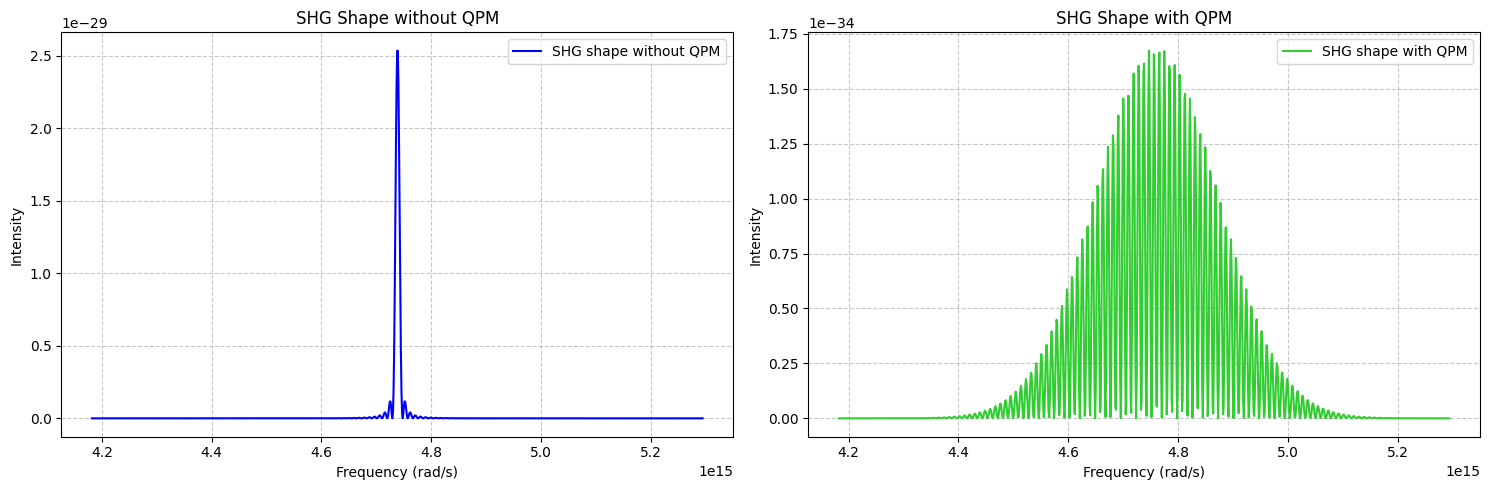

In [6]:
begin = 0
end = -1

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
SHG_frequencies_plot_interval = SHG_frequencies[begin: end]
SHG_shape_no_qpm_plot_interval = SHG_amplitud_no_QPM[begin: end]

plt.plot(SHG_frequencies_plot_interval, np.abs(SHG_shape_no_qpm_plot_interval)**2, label='SHG shape without QPM', color='blue')
plt.xlabel('Frequency (rad/s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('SHG Shape without QPM')
plt.ylabel('Intensity')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.subplot(1, 2, 2)

SHG_frequencies_plot_interval = SHG_frequencies[begin: end]
SHG_shape_with_qpm_plot_interval = SHG_amplitud_with_QPM[begin: end]

plt.plot(SHG_frequencies_plot_interval, np.abs(SHG_shape_with_qpm_plot_interval)**2, label='SHG shape with QPM', color='limegreen')
plt.xlabel('Frequency (rad/s)')
plt.title('SHG Shape with QPM')
plt.ylabel('Intensity')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.tight_layout()
plt.show()

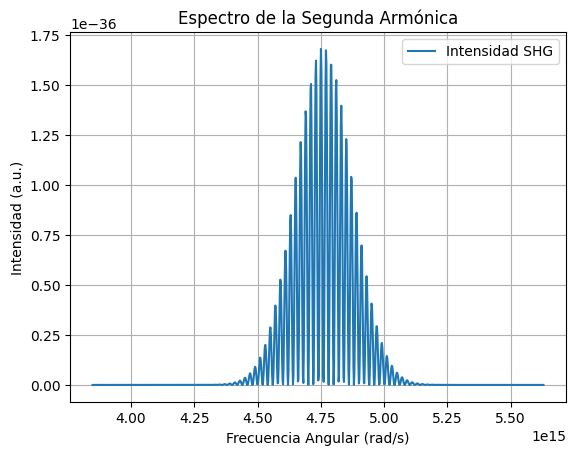

Valor máximo de SHG_amplitude: 1.2957e-18


In [7]:
input_pulse_omega = GaussianPulse1D(x0=fundamental_frequency, FWHM=FWHM_frequency, steps=1000, domain_width_std=8)
frequencies, A_omega = input_pulse_omega.generate_pulse(normalization=True)
SHG_frequencies = 2 * frequencies

# Llamada a la función
SHG_amp, freqs, pmf = second_harmonic_generation(A_omega, frequencies, SHG_frequencies, 0.795, 4e-3, 3.19)

# Visualización
plt.plot(SHG_frequencies, np.abs(SHG_amp)**2, label='Intensidad SHG')
plt.xlabel('Frecuencia Angular (rad/s)')
plt.ylabel('Intensidad (a.u.)')
plt.title('Espectro de la Segunda Armónica')
plt.legend()
plt.grid()
plt.show()

print(f"Valor máximo de SHG_amplitude: {np.max(np.abs(SHG_amp)):.4e}")

### Conjuntos de Parámetros para probar

Conjunto 1:

- Fundamental wavelength: 800e-9 m (0.8 μm)
- FWHM: 50e-9 m (50 nm)
- Cavity length: 0.005 m (5 mm)
- Poling period: 4.0 μm


Conjunto 2:

- Fundamental wavelength: 850e-9 m (0.85 μm)
- FWHM: 30e-9 m (30 nm)
- Cavity length: 0.003 m (3 mm)
- Poling period: None (sin QPM)

### Conjunto 1
---

In [8]:
# Parámetros iniciales
L_1 = 0.005  # Longitud de la cavidad en metros (5 mm)
gaussian_steps_1 = 1000  # Número de pasos para la simulación del pulso gaussiano 

# Parámetros del pulso en longitud de onda
input_width_wl_1 = 50e-9  # FWHM en metros (50 nm)
fundamental_wavelength_1 = 800e-9  # Longitud de onda central en metros (795 nm)
fundamental_wavelength_um_1 = fundamental_wavelength_1 * 1e6  # en μm (0.795 μm)

# Inicializar pulso en longitud de onda
input_pulse_1 = GaussianPulse1D(x0=fundamental_wavelength_1, FWHM=input_width_wl_1, steps=gaussian_steps_1, domain_width_std=5)
sigma_wavelength_1 = input_pulse_1.standard_deviation()  # ~1.8728e-08 m
wavelength_1, A_lambda_1 = input_pulse_1.generate_pulse(normalization=True)
wavelength_1, I_lambda_1 = input_pulse_1.generate_intensity()

# Conversión a frecuencia angular (rad/s)
c = 299792458  # Velocidad de la luz en m/s
fundamental_frequency_1 = 2 * np.pi * c / fundamental_wavelength_1  # Frecuencia angular central (rad/s)
sigma_frequency_1 = (2 * np.pi * c) / (fundamental_wavelength_1 ** 2) * sigma_wavelength_1  # Desviación en rad/s
FWHM_frequency_1 = sigma_frequency_1 * 2 * np.sqrt(2 * np.log(2))  # FWHM en rad/s

# Inicializar pulso en frecuencia
input_pulse_omega_1 = GaussianPulse1D(x0=fundamental_frequency_1, FWHM=FWHM_frequency_1, steps=gaussian_steps_1, domain_width_std=5)
frequencies_1, A_omega_1 = input_pulse_omega_1.generate_pulse(normalization=True)
frequencies_1, I_omega_1 = input_pulse_omega_1.generate_intensity(normalization=True)

# Parámetros para SHG
SHG_frequencies_1 = 2 * frequencies_1  # Frecuencias de la segunda armónica
SHG_wavelength_1 = fundamental_wavelength_1 / 2  # ~397.5 nm
SHG_wavelength_um_1 = SHG_wavelength_1 * 1e6  # ~0.3975 μm

# Imprimir parámetros
print("Parameters of the Gaussian pulse in wavelength domain:")
print("-" * 60)
pulse_dict_1 = input_pulse_1.as_dict()
for key, value in pulse_dict_1.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")

print("\n")
print("Parameters of the Gaussian pulse in frequency domain:")
print("-" * 60)
pulse_dict_omega_1 = input_pulse_omega_1.as_dict()
for key, value in pulse_dict_omega_1.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")

Parameters of the Gaussian pulse in wavelength domain:
------------------------------------------------------------
Center: 8.0000e-07
Fwhm: 5.0000e-08
Sigma: 2.1233e-08
Steps: 1000
Domain Width Std: 5
Computed Fwhm: 5.0001e-08


Parameters of the Gaussian pulse in frequency domain:
------------------------------------------------------------
Center: 2.3546e+15
Fwhm: 1.4716e+14
Sigma: 6.2493e+13
Steps: 1000
Domain Width Std: 5
Computed Fwhm: 1.4716e+14


In [9]:
SHG_amplitud_no_QPM_1, frequencies_1, pmf_no_QPM_1 = second_harmonic_generation(pulse_y=A_omega_1, pulse_x=frequencies_1, SHG_frequencies=SHG_frequencies_1,
                                                              fundamental_wavelength_um=fundamental_wavelength_um_1, cavity_length=L_1, poling_period_um=None)

poling_period_um_1 = 4.0  # Período QPM en micrómetros AFINAR VALOR DEL CRISTAL
SHG_amplitud_with_QPM_1, frequencies_1, pmf_with_QPM_1 = second_harmonic_generation(pulse_y=A_omega_1, pulse_x=frequencies_1, SHG_frequencies=SHG_frequencies_1,
                                                              fundamental_wavelength_um=fundamental_wavelength_um_1, cavity_length=L_1, poling_period_um=poling_period_um)

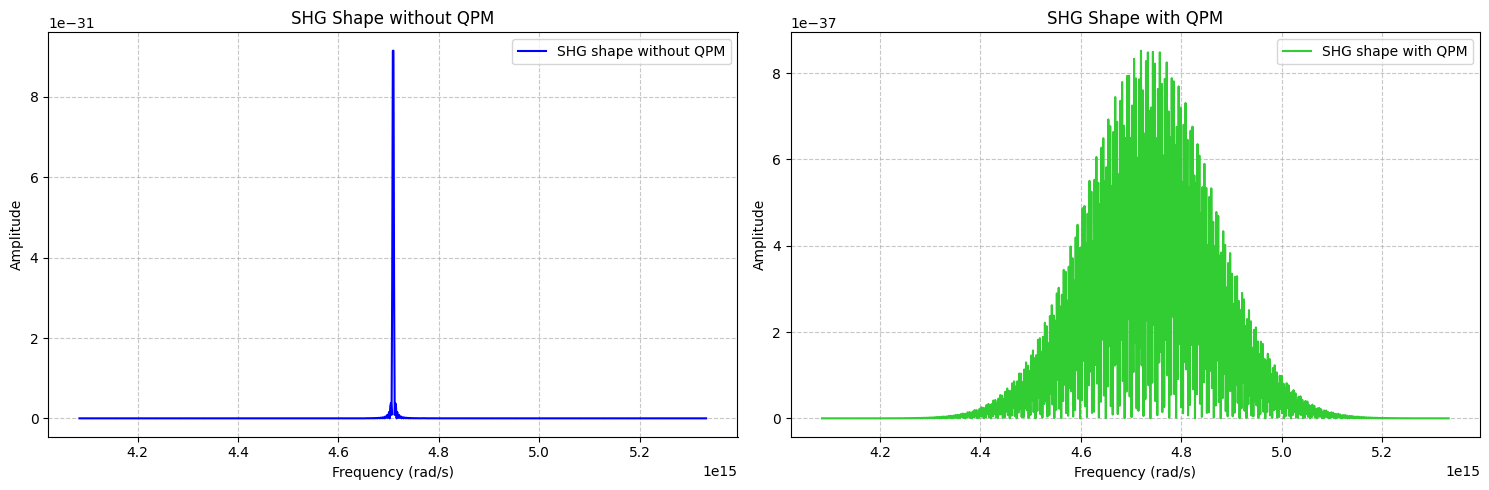

In [10]:
begin = 0
end = -1

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
SHG_frequencies_plot_interval_1 = SHG_frequencies_1[begin: end]
SHG_shape_no_qpm_plot_interval_1 = SHG_amplitud_no_QPM_1[begin: end]

plt.plot(SHG_frequencies_plot_interval_1, np.abs(SHG_shape_no_qpm_plot_interval_1)**2, label='SHG shape without QPM', color='blue')
plt.xlabel('Frequency (rad/s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('SHG Shape without QPM')
plt.ylabel('Amplitude')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.subplot(1, 2, 2)

SHG_frequencies_plot_interval_1 = SHG_frequencies_1[begin: end]
SHG_shape_with_qpm_plot_interval_1 = SHG_amplitud_with_QPM_1[begin: end]

plt.plot(SHG_frequencies_plot_interval_1, np.abs(SHG_shape_with_qpm_plot_interval_1)**2, label='SHG shape with QPM', color='limegreen')
plt.xlabel('Frequency (rad/s)')
plt.title('SHG Shape with QPM')
plt.ylabel('Amplitude')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.tight_layout()
plt.show()